# Lecture 7 - Classification & Regression (Logistic Regression)

Logistics Regression is a simple yet popular classification model. It is called Logistic *Regression* since outputs a numerical value. However, this numerical value is interpreted as the probability of a data sample belongs to Class 1 or Class 0 -- we only look at basic Logistic Regression which is defined for binary classification (although extended it to multiple classes is rather straightforward).

Compared to Linear Regression, Logistic Regression applies a non-linear function -- the Sigmoid function -- to the linear signal $h_\theta(x)$ to "force" the value into the range $[0, 1]$ to ensure valid probability values. As a consequence, Logistic Regression can no longer be solved analytically since there is no closed-form solution when setting the gradient to zero and trying to solve for $\theta$. Hence optimization methods such as Gradient Descent are needed.

Let's get started...

## Setting up the notebook

Specify how plots get rendered

In [1]:
%matplotlib notebook

Make all required imports. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

## Working with Toy Data (CSI Example)

As we did in the lecture, we adopt the simple CSI example we used for Linear Regression to a classification task. While the input is still the shoe print size of a person, the output is now a binary class label representing the sex of the person (woman: 0, man: 1)

In [3]:
data = np.array([
    (31.3, 1), (29.7, 1), (31.3, 0), (31.8, 0),
    (31.4, 1), (31.9, 1), (31.8, 1), (31.0, 1),
    (29.7, 0), (31.4, 1), (32.4, 1), (33.6, 1),
    (30.2, 0), (30.4, 0), (27.6, 0), (31.8, 1),
    (31.3, 1), (34.5, 1), (28.9, 0), (28.2, 0)
])

# Convert input and outputs to numpy arrays; makes some calculations easier
X = data[:,0].reshape(-1,1)
y = data[:,1]

We can still plot the data by using the class label is y coordinate in the scatter plot

<IPython.core.display.Javascript object>


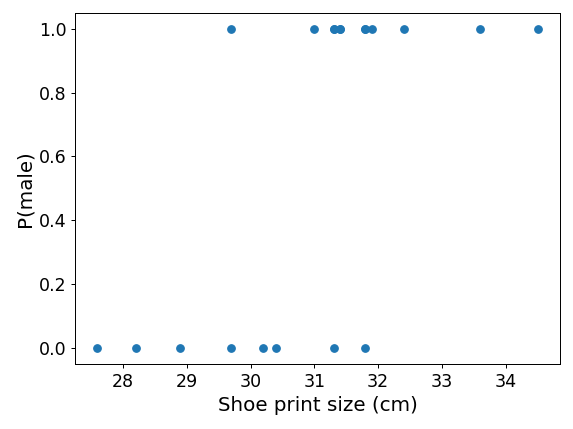

In [4]:
plt.figure()
plt.tick_params(labelsize=14)
plt.scatter(X, y)
plt.xlabel('Shoe print size (cm)', fontsize=16)
plt.ylabel('P(male)', fontsize=16)
plt.tight_layout()
plt.show()

We can see there is the expected trend that man generally have a larger show print size. But of course, there is not clear separation as there are tall women and small men with corresponding shoe print sizes. That means there will never be a perfect classifier to predict the sex of a person merely based on the size of a shoe print.

### Apply Logistic Regression

scikit-learn provides [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as implementation for Logistic Regression. Similar to the Linear Regression implementation, the model considers $\theta_0$ (`intercept_`) and $\theta_{i\neq 0}$ (`coef_`) separately. It also features the parameter `fit_intercept` whether to calculate the intercept $\theta_0$ or not.

Below, as we use the original data without adding the constant term ourselves, should set `fit_intercept=True`, which is the default value, so we can simply ignore it

In [5]:
clf = LogisticRegression().fit(X, y)

print('Intercept: {}, Coefficients: {}'.format(clf.intercept_, clf.coef_))

Intercept: [-32.93891359], Coefficients: [[1.07980603]]


We can visualize this result in two ways

* directly plotting the probabilities (see orange line in the plot below)
* plotting the decision boundary as defined by values for $\theta$

In [6]:
# Specify series of shoe print size in the range of the input data
x_range = np.arange(27, 35, 0.1).reshape(-1, 1)

# Calculate the probability for all shoe print size
# The method predict_proba() does this for us
y_best = clf.predict_proba(x_range)[:,1]

# Calculate the decision boundary
decision_boundary = clf.intercept_ +  clf.coef_[0] * x_range

We can now plot the probability values and the decision boundary together with the data sample in one figure.

<IPython.core.display.Javascript object>


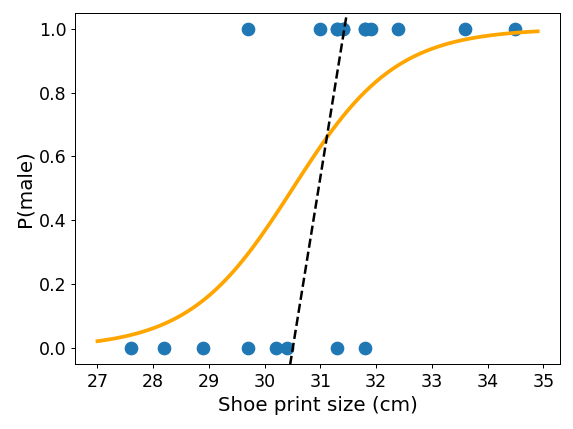

In [7]:
plt.figure()
plt.ylim(-0.05, 1.05)
plt.tick_params(labelsize=14)
plt.scatter(X, y, c='C0', s=100)
plt.plot(x_range, y_best, color='orange', lw=3)
plt.plot(x_range, decision_boundary, '--', color='black', lw=2)
plt.xlabel('Shoe print size (cm)', fontsize=16)
plt.ylabel('P(male)', fontsize=16)
plt.tight_layout()
plt.show()

As expected, the classification is not perfect.

### Predict Sex of Suspect

In our CSI example, the shoe print size we found of the suspect was 32.2 cm. So take this value as input for our model and look at the prediction. The method `predict()` directly returns the predicted class label (instead of the probabilities).

In [8]:
y_pred = clf.predict([[32.2]])

print('The predicted class label is: {}'.format(y_pred.squeeze()))

The predicted class label is: 1.0


A class label on 1 means the suspect is predicted to be a man. This output can already be seen when looking at the plot above. Also recall that the predicted height for the suspect was 185.7 cm (see notebook for Linear Regression) which is arguably more likely to be a man.

Apart from directly getting the class label, we can also look at the estimated probabilities. This gives us an incite how "sure" the classifier is about the returned label. Again, we use the method `predict_proba()` for that.

In [9]:
y_pred = clf.predict_proba([[32.2]])

print('The estimated probabilites are: {}'.format(y_pred.squeeze()))

The estimated probabilites are: [0.13813818 0.86186182]


In case of our suspect, the difference between the two probabilities is quite large, so we can be reasonably confident that the suspect is indeed a man -- although there will never be a 100% guarantee. Of course, both probabilities add up to 1.

Let's assume the size of the shoe print size of the suspect would have been 30.6 cm. We can estimate the probabilities for this value as well.

In [10]:
y_pred = clf.predict_proba([[30.6]])

print('The estimated probabilites are: {}'.format(y_pred.squeeze()))

The estimated probabilites are: [0.47423513 0.52576487]


As the probability for Class 1 is still higher than for Class 0, we still would predict the suspect to be a man. However, here the two probabilities are much closer, so we can say the level of confidence of the classifier is much lower. This kind of interpretation is pretty straightforward for binary classification but gets less obvious for multiple classes.

-----------------------------------------------

## Logistic Regression over Diabetes Dataset

The [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database) is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### Prepared Training & Test Data

#### Load Dataset from File

In [11]:
df_diabetes = pd.read_csv('data/diabetes.csv')

# Show the first 5 columns
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Generate Training & Test Data

As usual, we convert the dataframe into numpy arrays for further processing, including split the dataset into training and test data.

In [12]:
# Convert data to numpy arrays
X = df_diabetes[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy()
y = df_diabetes[['Outcome']].to_numpy().squeeze()

# Split dataset in to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=850)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))

Size of training set: 614
Size of test: 154


#### Normalize Data via Standardization

As already mentioned for Linear Regression, normalizing is often not required my in many cases recommended. As the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation applies regularization by default, we do normalize the data via standardization.

In [13]:
# We fit the scaler based on the training data only
scaler = StandardScaler().fit(X_train)

# Of course, we need to convert both training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Train and Evaluate Logistic Regression Classifier

We directly look into Polynomial Logistic Regression and try different maximum polynomial dregrees $p$ (similar to the Linear Regression notebook). Recall from the lecture that the number of terms given a polynomial degree of $p$ a number of input features $d$ is

$$
\#terms = \binom{p+d}{p}
$$

Since our dataset has 8 input features, this equation simplifies to

$$
\#terms = \binom{p+8}{8}
$$

Below we consider $p$ as our hyperparameter, i.e., we transform the dataset using different polynomial degrees, apply Logistic Regression, and check the f1 score for each setup. Note that we no have to set `fit_intercept=False` as  [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) adds the constant term to the data matrix even if $p=1$.

In [14]:
for p in range(1, 5):
    
    # Transform data w.r.t to degree of polynomial p
    poly = PolynomialFeatures(p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Train Linear Regressor or transformed data
    # fit_intercept=False since for p=1, transformation adds constant term to data
    poly_reg = LogisticRegression(C=1.0, fit_intercept=False, max_iter=1000).fit(X_train_poly, y_train)

    # Predict values for training and test set
    y_train_pred = poly_reg.predict(X_train_poly)
    y_test_pred = poly_reg.predict(X_test_poly)
    
    # Calculate MSE 
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    
    
    print('Degree of polynomial: {} => f1 (train/test): {:.2f}/{:.2f} (#terms: {})'.format(p, f1_train, f1_test, X_train_poly.shape[1]))

Degree of polynomial: 1 => f1 (train/test): 0.63/0.72 (#terms: 9)
Degree of polynomial: 2 => f1 (train/test): 0.70/0.64 (#terms: 45)
Degree of polynomial: 3 => f1 (train/test): 0.83/0.65 (#terms: 165)
Degree of polynomial: 4 => f1 (train/test): 0.95/0.57 (#terms: 495)


Here basic Logistic Regression without any larger polynomial terms performs best. Increasing $p$ quickly increases the number of polynomial and interaction terms as we have 8 features the allow for many combinations to form the terms. While the training score increases for larger values of $p$, the test score decreases. A clear sign of overfitting.

As [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) not only calculates the predicted class label but also return the respective probabilities, we can also evaluate trained models using the ROC curve and calculate the AU-ROC. for this we can simple re-use the method to plot the ROC curve from a previous notebook.

In [15]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("False Positive Rate (1-Specificity)", fontsize=16)
    plt.ylabel("True Positive Rate (Sensitivity)", fontsize=16)
    line = plt.plot(fpr, tpr, marker='o', lw=3, markersize=10, label='ROC curve (area = {:.2f})'.format(roc_auc))[0]
    line.set_clip_on(False)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()  

The following cell block performs all the required steps of the evaluation:
    
* Transform the data to include polynomial and interaction terms
* Fit a Logistic Regression model
* Calculate the probabilities in the test set
* Plot the ROC curve with the AUC-ROC value

You can try different values of $p$ and see how it changes the plot.

<IPython.core.display.Javascript object>


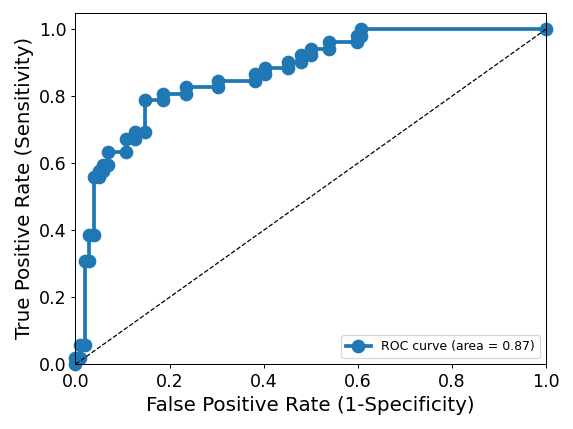

In [16]:
poly = PolynomialFeatures(1)
#poly = PolynomialFeatures(2)
#poly = PolynomialFeatures(3)
#poly = PolynomialFeatures(4)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
    
# Train Linear Regressor or transformed data
# fit_intercept=False since for p=1, transformation adds constant term to data
poly_reg = LogisticRegression(C=1.0, fit_intercept=False, max_iter=1000).fit(X_train_poly, y_train)

# Predict values and probabilities for test set
y_pred = poly_reg.predict(X_test_poly)
y_pred_proba = poly_reg.predict_proba(X_test_poly)

# As we have a binary task, we can focus on the probability for Class 1.
y_pred_proba = y_pred_proba[:,1]
    
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr, roc_auc)

Lastly, we can also perform a more proper evaluation using k-fold cross-validation to find the best value of $p$. To simplify things, we use the scikit-learn's method `cross_val_score()` to perform the cross-validation for us.

In [17]:
# Initialize the best f1-score and respective k value
best_p, best_f1 = None, 0.0

# Loop over a range of values for setting k
for p in range(1, 4):
    
    # Transform data w.r.t to degree of polynomial p
    poly = PolynomialFeatures(p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Specfify type of classifier
    clf = LogisticRegression(fit_intercept=False, max_iter=1000)
    
    # perform cross validation (here with 10 folds)
    # f1_scores is an array containg the 10 f1-scores
    f1_scores = cross_val_score(clf, X_train_poly, y_train, cv=10)
    
    # Calculate the f1-score for the current k value as the mean over all 10 f1-scores
    f1_fold_mean = np.mean(f1_scores)

    print('p={}, f1 score (mean/std): {:.3f}/{:.3f}'.format(p, f1_fold_mean, np.std(f1_scores)))
    
    # Keep track of the best f1-score and the respective k value
    if f1_fold_mean > best_f1:
        best_p, best_f1 = p, f1_fold_mean
  

print('The best f1-score was {:.3f} for p={}'.format(best_f1, best_p))

p=1, f1 score (mean/std): 0.759/0.044
p=2, f1 score (mean/std): 0.756/0.049
p=3, f1 score (mean/std): 0.702/0.069
The best f1-score was 0.759 for p=1


Again, $p=1$ yields the best average f1 score although the difference compared to the results for $p=2$ is rather small.

Having found the best value for $p$ we can now fit a Logistic Regression model on the whole training data and $p=1$ and evaluating the f1 score on the test data.

In [18]:
# Transform data
poly = PolynomialFeatures(1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# Fite Logistic Regression model on complete training data
clf = LogisticRegression(fit_intercept=False, max_iter=1000).fit(X_train, y_train)

# Predict class labels for test data
y_pred = clf.predict(X_test)

# Calculate f1 scores based on ground truth of test set
f1 = f1_score(y_test, y_pred)

print('F1 score of Linear Regression model on the test data: {:.3f}'.format(f1))

F1 score of Linear Regression model on the test data: 0.723


## Summary

Like Linear Regression for regression task, Logistic Regression as basic model to perform classification, benefits from its simplicity by showing fast training and generally a good interpretability. Depending on the underlying data, the model performance can also be very good -- and even outperform more complex models that generally require larger datasets to train, which are in practice often not available.